<a href="https://colab.research.google.com/github/talisma-cassoma/intellcapBot/blob/main/speciesRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

instalar dependencias 

In [1]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 30.61 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [2]:
%cd /content/Mask_RCNN

/content/Mask_RCNN


In [3]:
!pip install PyDrive


pegando imagens 

In [4]:
import firebase_admin
from firebase_admin import credentials

cred = credentials.Certificate('/content/drive/MyDrive/intellcapbot-firebase-adminsdk-gyxhm-394c38b13b.json')
firebase_admin.initialize_app(cred, {
    'databaseURL' : 'https://intellcapbot-default-rtdb.firebaseio.com'
}) 

In [5]:
from firebase_admin import db

ref = db.reference('/esp32-cam')

#base64_img_url = '{}'.format(ref.get())
#print(base64_img_url)

In [8]:
from PIL import Image
from io import BytesIO
import re, time, base64
from PIL import Image


def getImageFromBase64_Url(base64_img_url):

    #Using standard Base64 in URL requires encoding of '+', '/' and '=' characters into special percent-encoded hexadecimal 
    #sequences ('+' becomes '%2B', '/' becomes '%2F' and '=' becomes '%3D'), which makes the string unnecessarily longer.
    # see more at https://en.wikipedia.org/wiki/Percent-encoding
    percentEncoding=['%21','%23','%24', '%25', '%26', '%27', '%28','%29','%2A','%2B','%2C','%2F','%3A','%3B','%3D','%3F','%40','%5B','%5D']
    reservedCharacter=["!", "#", "$",	"%",	"&",	"'",	"(",	")",	"*",	"+"	, ",", "/",	":",	";",	"=",	"?",	"@",	"[",	"]"]
     
    if (base64_img_url.find("%")!=-1):
      #Replace "%2F" par  "/"
      for i in range(len(percentEncoding)):
         base64_img_url = base64_img_url.replace(percentEncoding[i], reservedCharacter[i])        

    base64_data = re.sub('^data:image/.+;base64,', '', base64_img_url)
    byte_data = base64.urlsafe_b64decode(base64_data) #string to binary image
    image_data = BytesIO(byte_data)                   # image to file-like object    
    img = Image.open(image_data)
    img.save('/content/saved.jpg', "JPEG")

    #im_arr = np.frombuffer(byte_data, dtype=np.int32) # byte to numpy array

In [7]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [9]:
downloaded = drive.CreateFile({'id':"1hcBNHFid8YqkH1z68ZNW7oWSEqCLSsBJ"})   # replace the id with id of file you want to access
downloaded.GetContentFile('recognition6.h5')        # replace the file name with your file

In [10]:

downloaded = drive.CreateFile({'id':"1zfu6CIumlIBnpApNaahTTvqmcUBEMsno"})   # replace the id with id of file you want to access
downloaded.GetContentFile('mask_rcnn_fish_cfg_0020.h5') 

In [11]:

downloaded = drive.CreateFile({'id':"1SZ2xeSnzyauBLD_cn3v9F_x4iUoRm7jD"})   # replace the id with id of file you want to access
downloaded.GetContentFile('finalized_modelKNN.sav') 

In [ ]:
!pip install TensorFlow==1.15 
!pip install keras==2.2.5 
!pip install -U scikit-image==0.16.2

In [16]:
!pip install h5py==2.10.0 

In [17]:
import tensorflow as tf
from os import listdir
from xml.etree import ElementTree
from numpy import argmax
from numpy import zeros
from numpy import asarray
from numpy import array
from numpy import expand_dims
from numpy import mean
from keras.models import load_model
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import pickle
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image 
import cv2

Using TensorFlow backend.


In [18]:
###### recognition model #######
model_rec = tf.keras.models.load_model(
    "recognition6.h5",
    custom_objects=None,
    compile=False
)
#load_model('recognition6.h5') ## load  the model 

def recognize_pic(file_path):  
    classes = {0:'abudefduf vaigiensis',1:'Amphiprion clarkii', 2:'Chaetodon lunulatus',
               3:'Chromis chrysura',4:'Myripristis kuntee'}
    image = Image.open(file_path)
    image = image.resize((30,30))
    image = expand_dims(image, axis=0)
    image = array(image)
    predicted = model_rec.predict(image) 
    indice=argmax(predicted)  
    
    return {"Name":classes[indice],"Accuracy":predicted[0,indice]} 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
### classification model ###
filename = 'finalized_modelKNN.sav' 
loaded_model = pickle.load(open(filename, 'rb')) ## load  the model 

def classify(taille,prof,temp,kh,ph):
    param_list=list()
    param_list.append(int(taille))
    param_list.append(int(prof))
    param_list.append(int(temp))  
    param_list.append(int(kh))    
    param_list.append(float(ph))

    return loaded_model.predict([param_list])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "fish_cfg"
    # number of classes (background + fish)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights(r'mask_rcnn_fish_cfg_0020.h5', by_name=True)

In [22]:
import copy
from google.colab.patches import cv2_imshow

def runModel():
    print("\n ============================= Loading image========================= \n ")

    base64_img = '{}'.format(ref.get())       #pegar url do firebase
    getImageFromBase64_Url(base64_img)        #salvar a imagem

    imageT = cv2.imread("/content/saved.jpg") #ler imagem
    cv2_imshow(imageT)
    imageT=cv2.resize(imageT,(500,500))
    clone_img = copy.copy(imageT)
    image = img_to_array(imageT)
    data = array(image, dtype="int32")

    # convert pixel values (e.g. center)
    scaled_image = mold_image(data,cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    print("\n =========================== Release Detecting model ============================ \n ")
    yhat = model.detect(sample, verbose=0)[0]
    #print(yhat["scores"])
    path_crop="image_test\\"
    font = cv2.FONT_HERSHEY_SIMPLEX
    for box,sc in zip(yhat['rois'],yhat["scores"]) :
        # the accuracy of detection high that 87%
        
        if float(sc) > float(0.7) :
            # get coordinates
            y1, x1, y2, x2 = box
            #crop the image of detected fish
            crop_img = clone_img[y1:y2, x1:x2]
            #save the image
            path_crop_img="image_test\\"+str(y1)+".jpg"
            cv2.imwrite(path_crop_img,crop_img)
            #recognize the fish detected
            print("\n======================== release recognition model  ================================ \n")
            pred_recognition=recognize_pic(path_crop_img)
            if(pred_recognition["Accuracy"]>0.8):
                print("\n============== The Accuracy equals to : "+str((pred_recognition["Accuracy"]*100))+"% ============ \n")
            #draw a rectangle on detected fish
                cv2.rectangle(imageT,(x1,y1),(x2,y2),(0,255,0))
            #put the name of the fish 
                cv2.putText(imageT, pred_recognition["Name"], (x1, y1),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
            elif(pred_recognition["Accuracy"]>0.4):
                print("\n ====================== The Accuracy of recognition model is less than 80% ==================== \n ")
                print("\n ==================== Get the environment parameters============================= \n ")
                print("\n ===================== Release the classification Model ========================= \n ")
                name=classify(taille,prof,temp,kh,ph)
                if(name==pred_recognition["Name"]):
                    cv2.rectangle(imageT,(x1,y1),(x2,y2),(0,255,0))
            #put the name of the fish 
                    cv2.putText(imageT, pred_recognition["Name"], (x1, y1),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
                
    print("\n ===================== Finished process=======================  \n")        
    #cv2.imshow("all", imageT)
    cv2_imshow(imageT)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()        
    


 ============================= Loading image========================= 
 


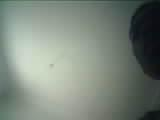


 =========================== Release Detecting model ============================ 
 

 ===================== Finished process=======================  



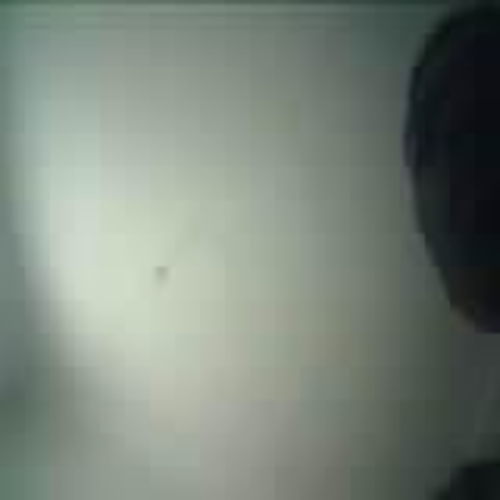


 ============================= Loading image========================= 
 


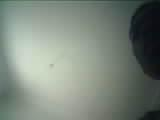


 =========================== Release Detecting model ============================ 
 

 ===================== Finished process=======================  



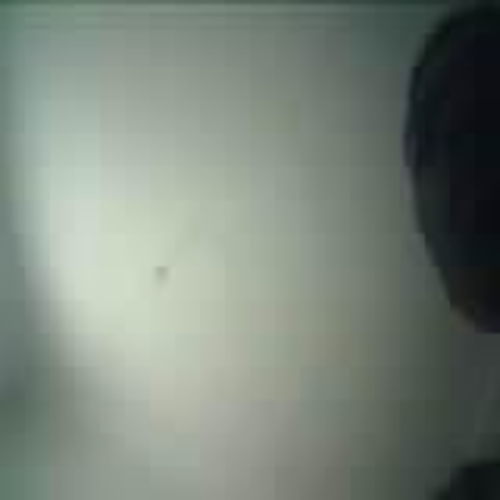

In [24]:
loop=0
while loop<2 :
  runModel()
  loop=loop+1

postando imagem no firebase 